In [166]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [167]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [168]:
@njit()
# @jit(nopython=True)
def main_function():
    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    # step_ind.append(0.05)
    # step_vol.append(0.05)
    # w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents()  # Случано сгенерированное текущее поколение

    # P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    # p_qbest_list.append(p_qbest)
    p_qbest_list[t] = p_qbest

    # f_t = list()
    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t
    # F = [numpy.array(f_t)]

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        # step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        # step_vol.append(step_vol[0] * exp(-y * t / iter_max))
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        # P.append(numpy.copy(P[t - 1]))
        # w.append(numpy.copy(w[t - 1]))
        # F.append(numpy.zeros(number_of_agents))
        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        # delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = sum(P_mul_F[:][j])
            # for i in range(number_of_agents):
            #     s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            # sm = sum(P[t][:][j] + w[t][:])
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = sum(w[t])
        # for i in range(number_of_agents):
        #     sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        # p_qbest_list.append(p_qbest)
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [169]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [170]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [171]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [172]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [173]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-2.04394572  0.08493766]
The function value of pqbest:		5.954307946989289
Algorithm running time:			4.802570581436157 s


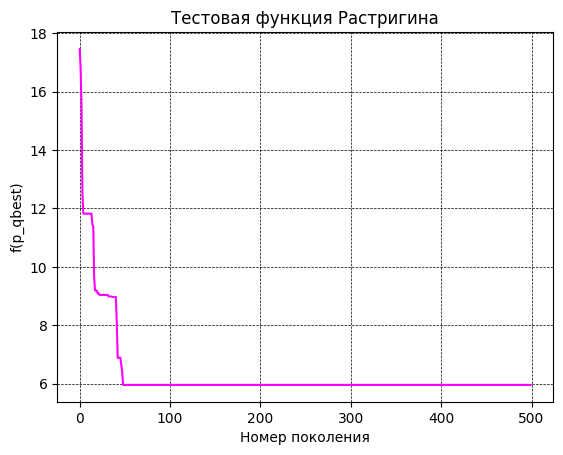

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.05554869 0.01147076]
The function value of pqbest:		0.6321046926448801
Algorithm running time:			0.03328132629394531 s


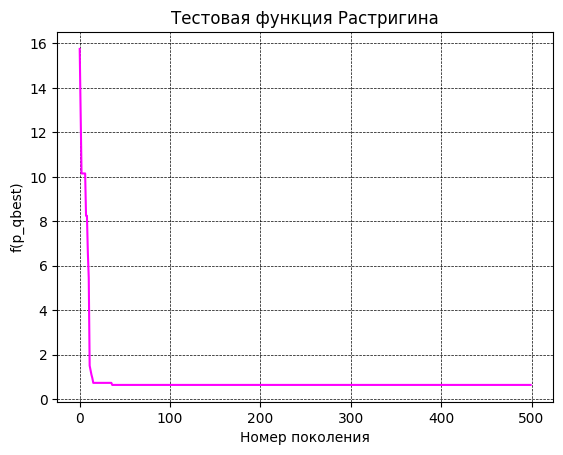

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 1.01526689 -0.93511376]
The function value of pqbest:		2.7707944334512504
Algorithm running time:			0.024016618728637695 s


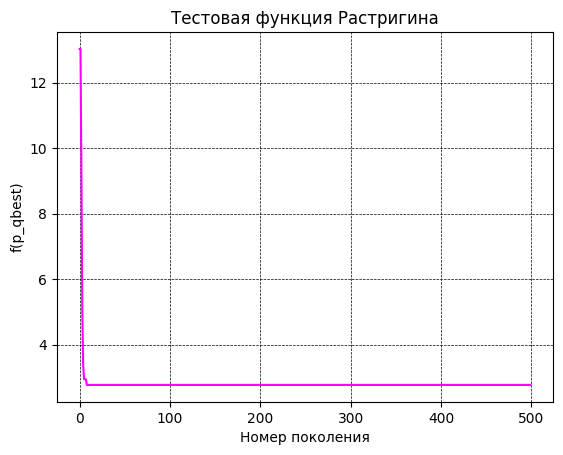

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.05256126 -0.96574233]
The function value of pqbest:		1.7065787766363059
Algorithm running time:			0.03998613357543945 s


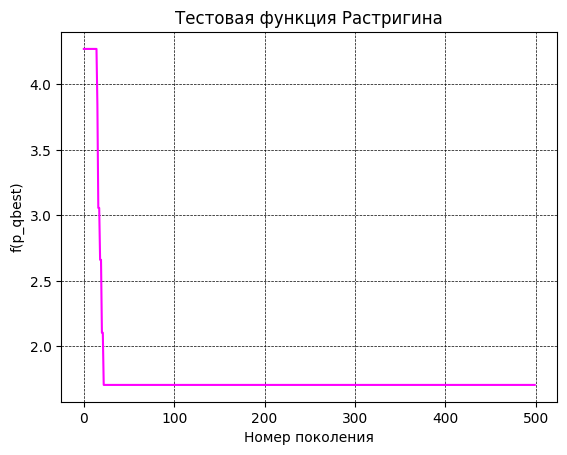

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-1.02278684  0.0552413 ]
The function value of pqbest:		1.7478022655130019
Algorithm running time:			0.02398371696472168 s


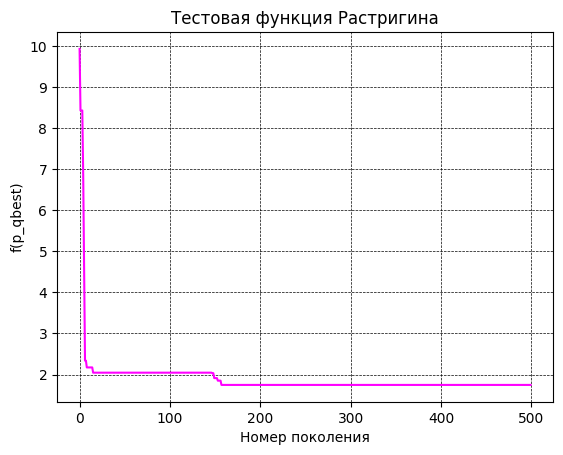

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.00732253 -0.08978211]
The function value of pqbest:		1.568089506525851
Algorithm running time:			0.03200268745422363 s


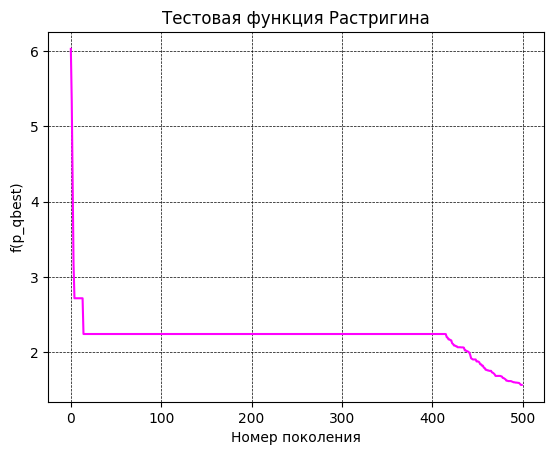

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.95232971  0.9691677 ]
The function value of pqbest:		2.478500170104695
Algorithm running time:			0.032003164291381836 s


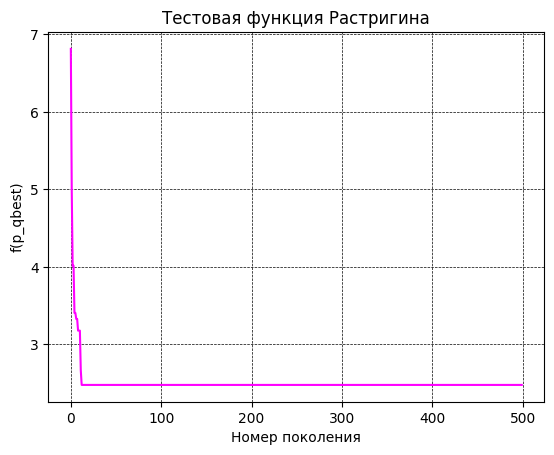

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.98079288  1.00781206]
The function value of pqbest:		2.0624161409970228
Algorithm running time:			0.03999757766723633 s


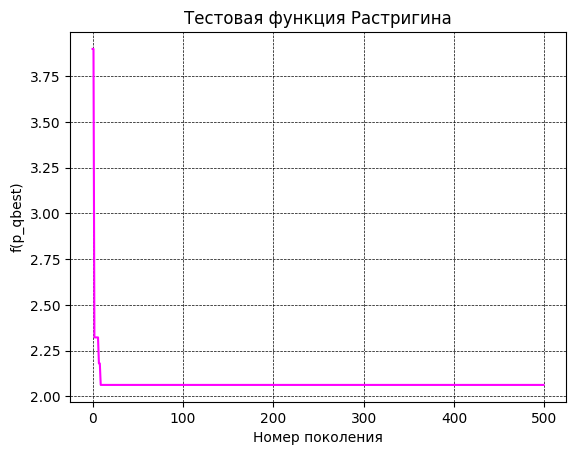

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.95256188 -1.03349474]
The function value of pqbest:		2.6370504247472724
Algorithm running time:			0.03202080726623535 s


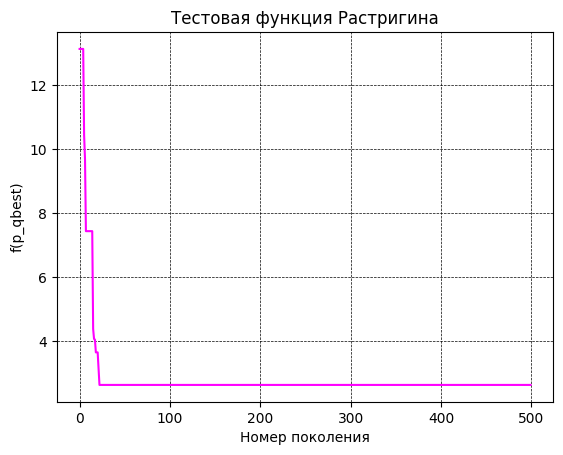

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.99711325  0.01296097]
The function value of pqbest:		1.029188651951344
Algorithm running time:			0.03200364112854004 s


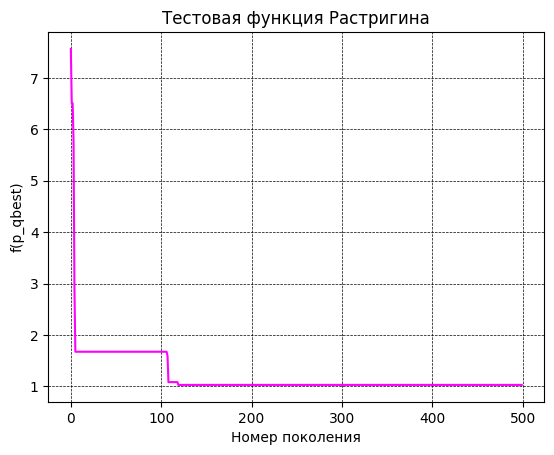

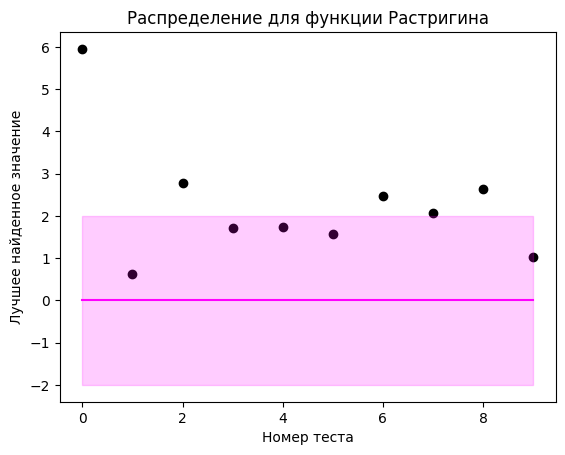

In [174]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [175]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [176]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5, 5, n_args_count)
    # return result
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.11351925 -0.07129712]
The function value of pqbest:		0.8033458460042588
Algorithm running time:			0.040018320083618164 s


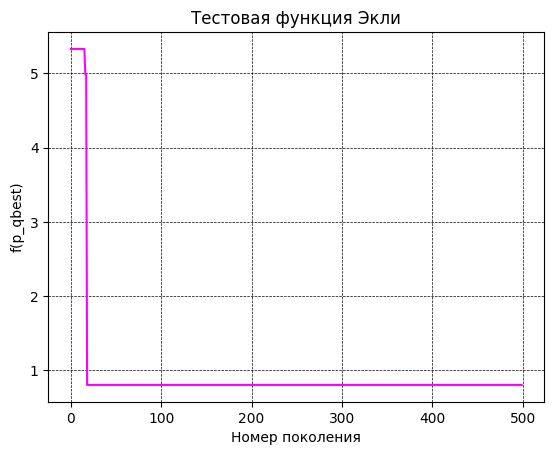

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.01423845 -0.99892949]
The function value of pqbest:		2.640612161102446
Algorithm running time:			0.03200054168701172 s


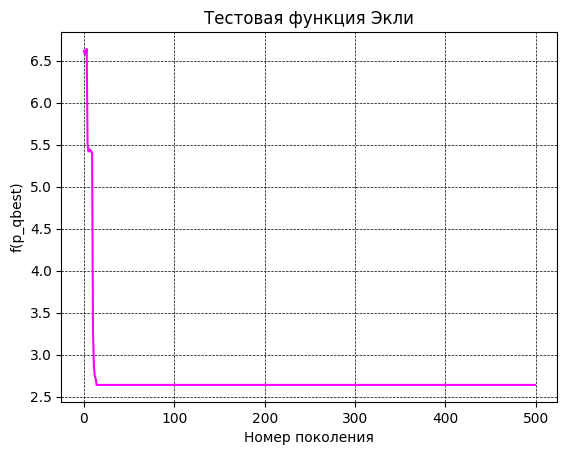

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.04031904 0.02086187]
The function value of pqbest:		0.18247551752990177
Algorithm running time:			0.03672480583190918 s


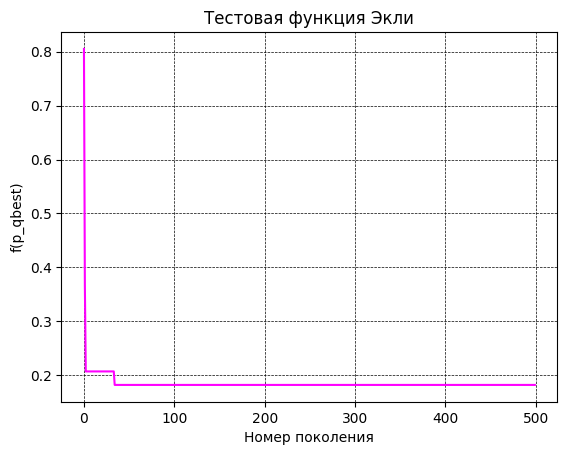

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.00157841  0.99654212]
The function value of pqbest:		2.6294291029747434
Algorithm running time:			0.03202199935913086 s


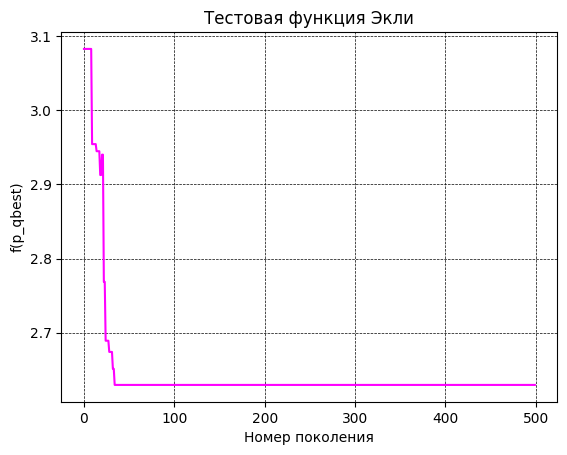

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.89262797 -0.01180358]
The function value of pqbest:		2.657432233766613
Algorithm running time:			0.04002118110656738 s


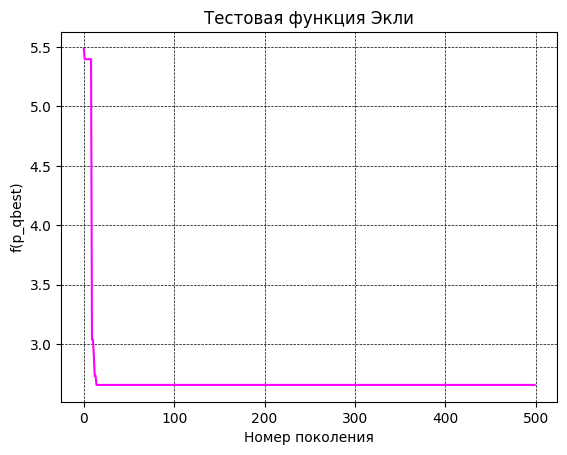

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.97674425  1.02937815]
The function value of pqbest:		3.6738512992483194
Algorithm running time:			0.0240170955657959 s


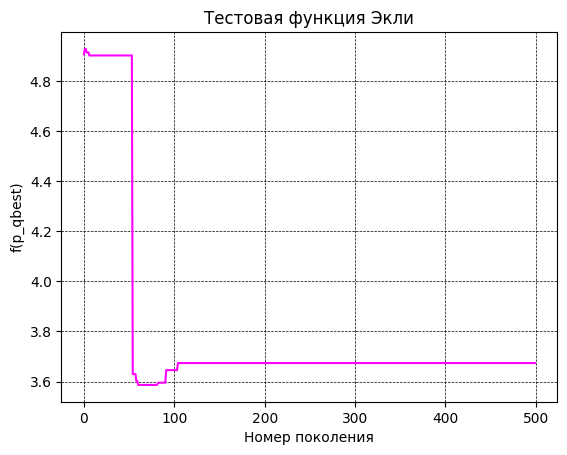

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.98156752 -1.99916116]
The function value of pqbest:		5.4128074572935425
Algorithm running time:			0.03199267387390137 s


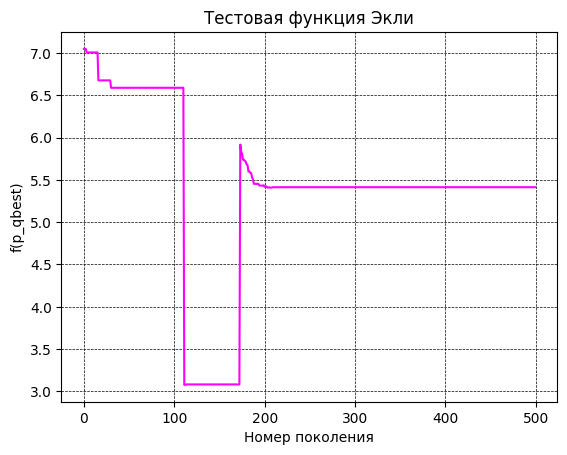

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.91491855 -0.96822061]
The function value of pqbest:		3.642379854559369
Algorithm running time:			0.02401876449584961 s


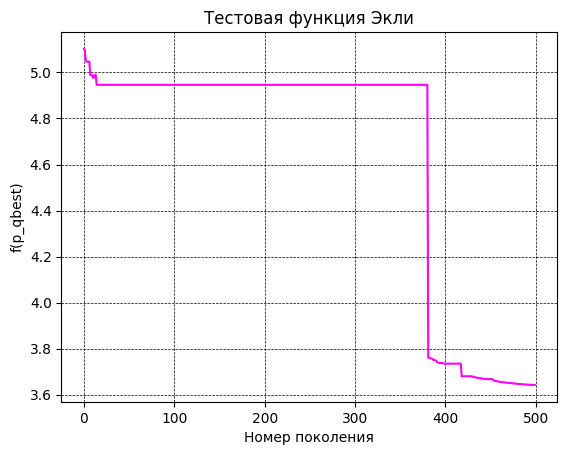

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.99411311 -0.01006597]
The function value of pqbest:		2.626840131813953
Algorithm running time:			0.03201603889465332 s


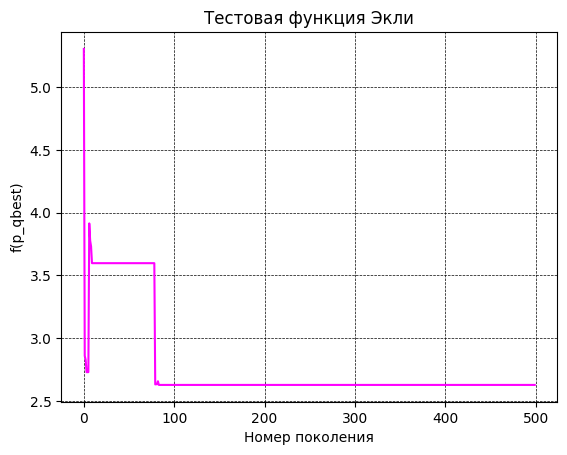

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.01166556 -1.01611302]
The function value of pqbest:		2.6878025222647004
Algorithm running time:			0.024001598358154297 s


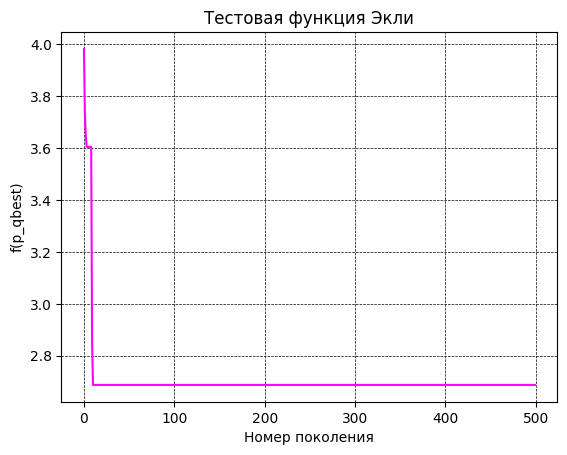

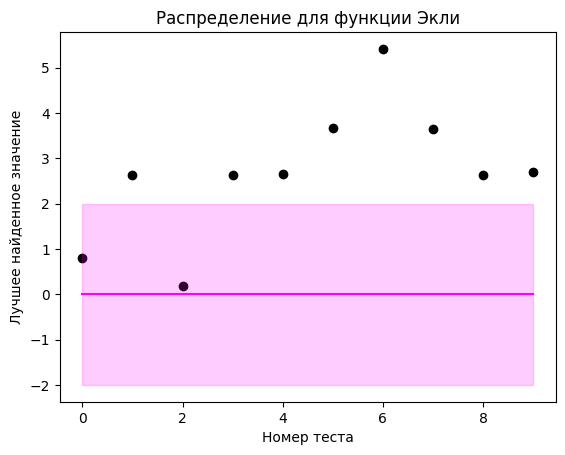

In [177]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [178]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [179]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-10, 10, n_args_count)
    # return result
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[1.00843616 1.01870639]
The function value of pqbest:		2.054706195338554
Algorithm running time:			0.024010181427001953 s


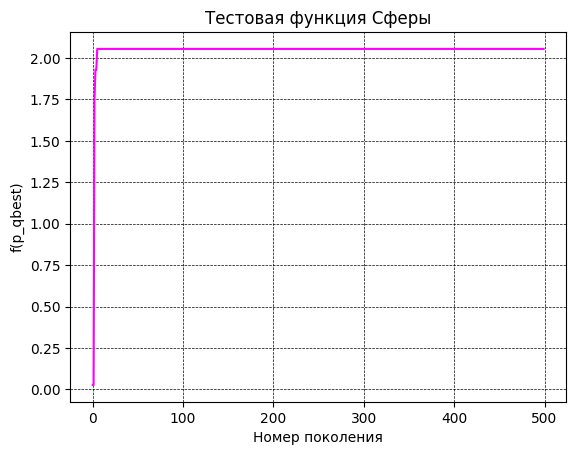

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.04798368  0.03929309]
The function value of pqbest:		0.003846380314101349
Algorithm running time:			0.024013757705688477 s


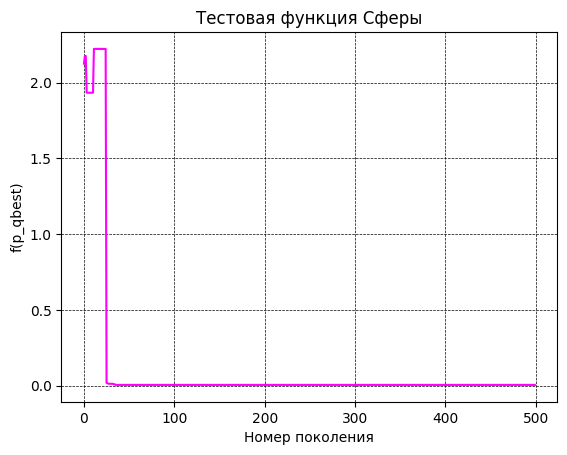

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.08921015 -0.00736042]
The function value of pqbest:		0.008012626895645539
Algorithm running time:			0.023984432220458984 s


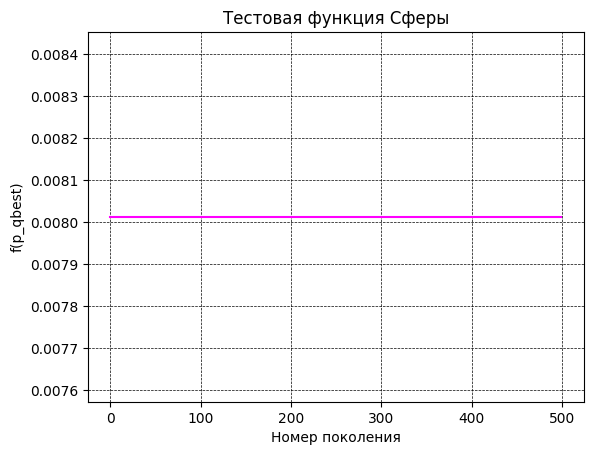

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-1.99074621  0.02713673]
The function value of pqbest:		3.9638068728711366
Algorithm running time:			0.03199911117553711 s


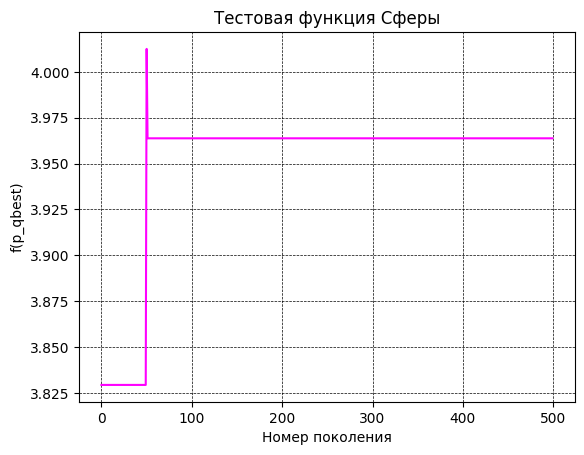

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.95937318 1.12131529]
The function value of pqbest:		5.096491248911935
Algorithm running time:			0.01598834991455078 s


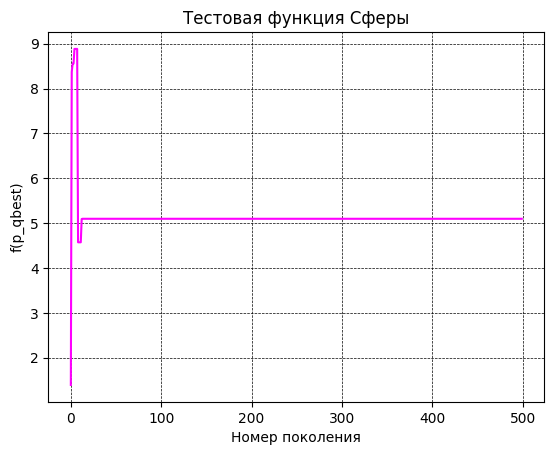

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.05268025  1.00196432]
The function value of pqbest:		1.0067077040750847
Algorithm running time:			0.01600170135498047 s


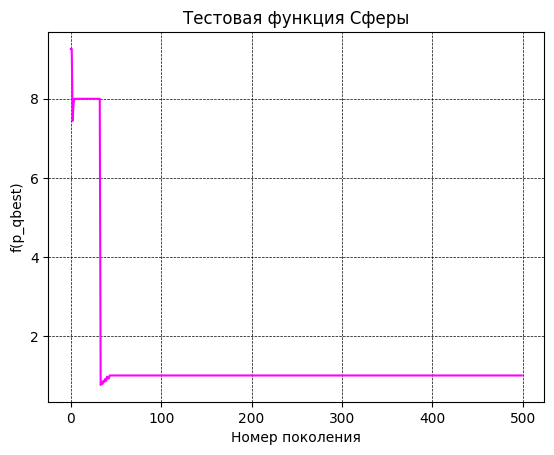

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.01254405  0.05686014]
The function value of pqbest:		0.0033904284717514222
Algorithm running time:			0.02398824691772461 s


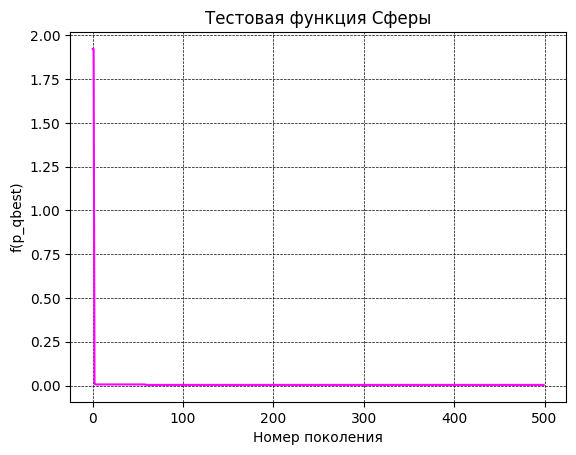

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.99293237 0.09413807]
The function value of pqbest:		0.9947766591721264
Algorithm running time:			0.016001224517822266 s


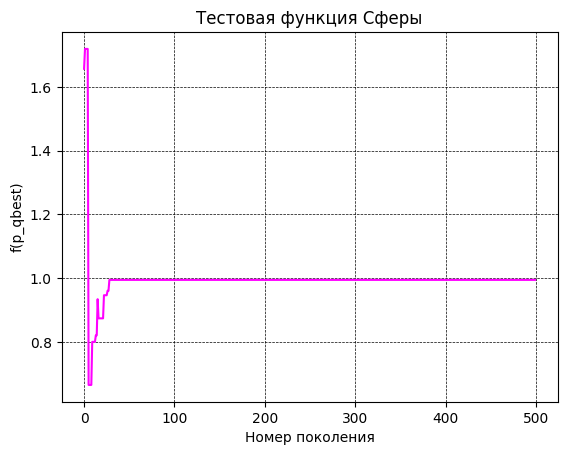

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.01872431 -1.00082609]
The function value of pqbest:		1.00200345834776
Algorithm running time:			0.023985624313354492 s


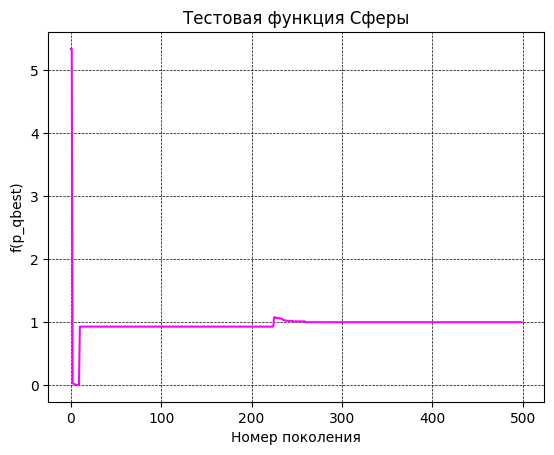

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[8.73545132e-03 5.80907648e-05]
The function value of pqbest:		7.631148424547324e-05
Algorithm running time:			0.01599597930908203 s


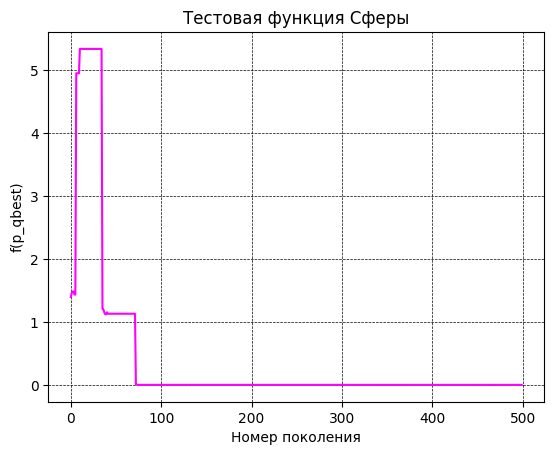

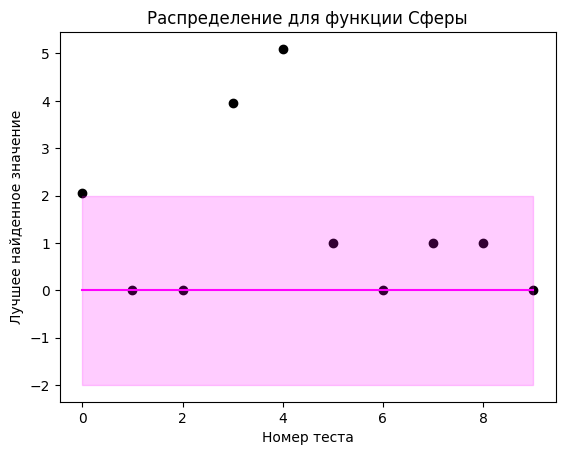

In [180]:
start_test("Сферы")
